In [1]:
import numpy as np
import pandas as pd
import os
import sys
import logging
import time

%load_ext autoreload
%autoreload 2
# %aimport features

curr_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(curr_dir)
sys.path.append(parent_dir+'/src')

from utils import *
from features import *
from preprocess import *
from models import *


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

2023-08-20 11:30:11,782 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


### 1. 加载数据

In [2]:
# 加载数据
item_data = pd.read_csv('../data/raw/tianchi_mobile_recommend_train_item.csv')
user_data = pd.read_csv('../data/raw/tianchi_mobile_recommend_train_user.csv')
item_df = item_data.copy()
user_data['cnt'] = 1
user_data['user_item_id'] =  user_data['user_id'].astype(str) + '_' + user_data['item_id'].astype(str)
user_df = user_data.groupby(['user_item_id', 'user_id', 'item_id', 'time', 'behavior_type'])['cnt'].count().reset_index()
user_df['time_day'] = user_df['time'].apply(lambda x: x[:10])
user_df['time'] = pd.to_datetime(user_df['time'], format='%Y-%m-%d %H')
# 标签
user_df['label'] = user_df['behavior_type'].apply(lambda x: 1 if x==4 else 0)

In [3]:
print(user_df.shape)
user_df.head()

(6213379, 8)


,user_item_id,user_id,item_id,time,behavior_type,cnt,time_day,label
0,100001878_100456318,100001878,100456318,2014-12-15 06:00:00,1,3,2014-12-15,0
1,100001878_100517114,100001878,100517114,2014-12-04 12:00:00,1,3,2014-12-04,0
2,100001878_101061643,100001878,101061643,2014-12-12 15:00:00,1,3,2014-12-12,0
3,100001878_101832988,100001878,101832988,2014-12-13 00:00:00,1,2,2014-12-13,0
4,100001878_101873851,100001878,101873851,2014-11-24 17:00:00,1,3,2014-11-24,0


In [11]:
# 样本数据
# 训练集
# train_label_df = user_df[user_df['time_day'] == '2014-12-17'][['user_id', 'item_id', 'label']].drop_duplicates()
# train_df = pd.merge(train_label_df, select_train_feat_df, on = ['user_id', 'item_id'], how = 'left')
# train_pos_df = train_df[train_df['label'] == 1]
# train_df = pd.concat([train_df] + [train_pos_df]*10).reset_index(drop=True)
# X_train, y_train = train_df.drop(columns = ['user_id', 'item_id', 'sample_date', 'label']), train_df['label']
# 验证集
# valid_label_df = user_df[user_df['time_day'] == '2014-12-18'][['user_id', 'item_id', 'label']].drop_duplicates()
# valid_df = pd.merge(valid_label_df, select_valid_feat_df, on = ['user_id', 'item_id'], how = 'left')
# valid_df['data_date'] = '2014-12-18'
# valid_pos_df = valid_df[valid_df['label'] == 1]
# valid_df = pd.concat([valid_df] + [valid_pos_df]*10).reset_index(drop=True)
# X_valid, y_valid = valid_df.drop(columns = ['user_id', 'item_id', 'data_date', 'label']), valid_df['label']

# 训练集样本数据
train_sample_df = user_df[user_df['time_day'] == '2014-12-17'][['user_id', 'item_id', 'label']].drop_duplicates().reset_index(drop=True)
train_sample_df['sample_date'] = '2014-12-17'
train_sample_df['sample_date'] = pd.to_datetime(train_sample_df['sample_date'])
# 验证集样本数据
valid_sample_df = user_df[user_df['time_day'] == '2014-12-18'][['user_id', 'item_id', 'label']].drop_duplicates().reset_index(drop=True)
valid_sample_df['data_date'] = '2014-12-18'
valid_sample_df['data_date'] = pd.to_datetime(valid_sample_df['data_date'])


In [12]:
train_sample_df.head()
valid_sample_df.head()
user_df.head()
logger.info('train_sample_df.shape = {}'.format(train_sample_df.shape))
logger.info('valid_sample_df.shape = {}'.format(valid_sample_df.shape))
logger.info('user_df.shape = {}'.format(user_df.shape))

2023-08-20 11:41:34,018 - __main__ - INFO - train_sample_df.shape = (169279, 4)
2023-08-20 11:41:34,019 - __main__ - INFO - valid_sample_df.shape = (165798, 4)
2023-08-20 11:41:34,021 - __main__ - INFO - user_df.shape = (6213379, 8)


In [14]:
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169279 entries, 0 to 169278
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      169279 non-null  int64         
 1   item_id      169279 non-null  int64         
 2   label        169279 non-null  int64         
 3   sample_date  169279 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.2 MB


In [8]:
print(user_df['behavior_type'].unique())
user_df.head()

[1 3 4 2]


,user_item_id,user_id,item_id,time,behavior_type,cnt,time_day,label
0,100001878_100456318,100001878,100456318,2014-12-15 06:00:00,1,3,2014-12-15,0
1,100001878_100517114,100001878,100517114,2014-12-04 12:00:00,1,3,2014-12-04,0
2,100001878_101061643,100001878,101061643,2014-12-12 15:00:00,1,3,2014-12-12,0
3,100001878_101832988,100001878,101832988,2014-12-13 00:00:00,1,2,2014-12-13,0
4,100001878_101873851,100001878,101873851,2014-11-24 17:00:00,1,3,2014-11-24,0


In [55]:
import numpy as np
import pandas as pd

tmp_df = pd.DataFrame({'id': ['a']*10000000,
                       'val': np.random.randint(0, 10, size=[10000000]),
                       'flag': np.random.randint(0, 2, size=[10000000])})
tmp_df.head()

,id,val,flag
0,a,0,0
1,a,4,0
2,a,1,1
3,a,5,0
4,a,9,1


In [66]:
tmp_df.values

array([['a', 0, 0],
       ['a', 4, 0],
       ['a', 1, 1],
       ...,
       ['a', 9, 0],
       ['a', 3, 1],
       ['a', 4, 1]], dtype=object)

In [65]:
import pandas as pd

# 使用 itertuples() 遍历每一行
for row in tmp_df.itertuples(index=False):
    print(row)
    column_id = row.id
    column_val = row.val
    column_flag = row.flag
    print(column_a, column_b, column_flag)
    break

Pandas(id='a', val=0, flag=0)
a 0 0


In [69]:
import time
start_time = time.time()
lst = []
for row in tmp_df.values:
    if row[2] == 0:
        lst.append(list(row))
end_time = time.time()
run_time = end_time - start_time
print("values形式 代码运行时间为：", run_time, "秒")

import time
start_time = time.time()
lst = []
for row in tmp_df.itertuples():
    if row[2] == 0:
        lst.append(list(row))
end_time = time.time()
run_time = end_time - start_time
print("itertuples形式 代码运行时间为：", run_time, "秒")

import time
start_time = time.time()
lst = []
for row in tmp_df.to_numpy():
    if row[2] == 0:
        lst.append(list(row))
end_time = time.time()
run_time = end_time - start_time
print("to_numpy形式 代码运行时间为：", run_time, "秒")

start_time = time.time()
lst = []
for _, row in tmp_df.iterrows():
    if row['flag'] == 0:
        lst.append(list(row))
end_time = time.time()
run_time = end_time - start_time
print("iterrows形式 代码运行时间为：", run_time, "秒")

values形式 代码运行时间为： 9.425453901290894 秒
itertuples形式 代码运行时间为： 6.62873387336731 秒
to_numpy形式 代码运行时间为： 8.158014059066772 秒


KeyboardInterrupt: 

In [7]:
import time
start_time = time.time()
lst = []
for _, row in tmp_df.iterrows():
    if row['flag'] == 0:
        lst.append(list(row))
end_time = time.time()
run_time = end_time - start_time
print("代码运行时间为：", run_time, "秒")

代码运行时间为： 565.9101419448853 秒


In [19]:
tmp_df = user_df.groupby('user_id')['item_id'].count().reset_index()
tmp_df.sort_values(by = ['item_id'], ascending=False, inplace=True)
tmp_df

,user_id,item_id
2553,36233277,15936
5053,73196588,15627
4541,65645933,12427
4121,59511789,11196
534,7234861,9053
...,...,...
947,12947756,1
258,3421308,1
2537,35935190,1
1395,19818801,1


### 2. 特征衍生

In [16]:

start_time = time.time()

FeatureExtractor(
    base_table=train_sample_df,
    base_partition_col_idx=0,
    base_sort_col_idx=3,
    base_prod_col_idx=1,
    join_table=user_df,
    join_partition_col_idx=1,
    join_sort_col_idx=3,
    join_prod_col_idx=2,
    mode='two',
    windows=[1, 5, 7, 14, 30],
    calc_configs=[
        {'col': 'cnt', 'stats': ['sum', 'mean']},
        {'col': 'cnt', 'stats': ['sum', 'mean'], 'condition': {'behavior_type': [1,2,3,4]}},
    ],
    feat_prefix='f',
).sort_by_key()\
    .map_partition3()

end_time = time.time()
run_time = end_time - start_time
print("代码运行时间为：", run_time/60, "分")


KeyboardInterrupt: 

In [ ]:
train_feat_df.shape

### 3. 特征选择

In [5]:
selector = FeatureSelector(data = train_feat_df)

logger.info('train_feat_df.shape = {}'.format(train_feat_df.shape))
logger.info('valid_feat_df.shape = {}'.format(train_feat_df.shape))

selection_params = {'missing_threshold': 0.9, 'variance_threshold': 0}
select_train_feat_df = selector.all_filter(selection_params=selection_params)

select_valid_feat_df = valid_feat_df.drop(columns = selector.feats_to_drop)

logger.info('select_train_feat_df.shape = {}'.format(select_train_feat_df.shape))
logger.info('select_valid_feat_df.shape = {}'.format(select_valid_feat_df.shape))

2023-08-02 08:23:58,927 - __main__ - INFO - train_feat_df.shape = (4686904, 77)
2023-08-02 08:23:58,929 - __main__ - INFO - valid_feat_df.shape = (4686904, 77)
2023-08-02 08:24:05,377 - features.feature_selector - INFO - 过滤缺失率>0.9的特征，共28个特征
2023-08-02 08:24:23,088 - features.feature_selector - INFO - 过滤方差<=0的特征，共0个特征
2023-08-02 08:24:38,626 - __main__ - INFO - select_train_feat_df.shape = (4686904, 49)
2023-08-02 08:24:38,630 - __main__ - INFO - select_valid_feat_df.shape = (4686904, 49)


### 4. 模型训练、参数调优

In [34]:
tuner = LightGBMModel(X_train, y_train, X_valid, y_valid, task='classification')
model = tuner.train()

[I 2023-08-02 10:14:00,407] A new study created in memory with name: no-name-8cb0c1c2-97bd-4b7c-8821-68098bac8dbd


[LightGBM] [Warning] feature_fraction is set=0.8184684241726381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8184684241726381
[LightGBM] [Warning] bagging_fraction is set=0.6560938169024613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560938169024613
[LightGBM] [Warning] feature_fraction is set=0.8184684241726381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8184684241726381
[LightGBM] [Warning] bagging_fraction is set=0.6560938169024613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560938169024613
[LightGBM] [Info] Number of positive: 3130, number of negative: 166149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6373
[LightGBM] [Info] Number of data points in the train set: 169279

[I 2023-08-02 10:14:02,221] Trial 0 finished with value: 0.7290373958262149 and parameters: {'max_depth': 4, 'n_estimators': 150, 'learning_rate': 0.09895333808306755, 'feature_fraction': 0.8184684241726381, 'bagging_fraction': 0.6560938169024613, 'min_child_samples': 27}. Best is trial 0 with value: 0.7290373958262149.


[LightGBM] [Warning] feature_fraction is set=0.8308916524067604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8308916524067604
[LightGBM] [Warning] bagging_fraction is set=0.32823291243944397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32823291243944397
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.8308916524067604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8308916524067604
[LightGBM] [Warning] bagging_fraction is set=0.32823291243944397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32823291243944397
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3130, number of negative: 166149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[W 2023-08-02 10:14:06,615] Trial 1 failed with parameters: {'max_depth': 10, 'n_estimators': 860, 'learning_rate': 0.17445685381805018, 'feature_fraction': 0.8308916524067604, 'bagging_fraction': 0.32823291243944397, 'min_child_samples': 12} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/chenzhao/opt/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/Users/chenzhao/Desktop/龙盈智达/基于订单数据的目标客群模块通用化/project-name/src/models/model_builder.py", line 80, in objective_classification
    model.fit(self.X_train, self.y_train)
  File "/Users/chenzhao/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 1142, in fit
    super().fit(
  File "/Users/chenzhao/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/Users/chenzhao/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py",

KeyboardInterrupt: 

In [21]:
logger.info('best params: {}'.format(tuner.best_params))
logger.info('best score: {}'.format(tuner.best_score))


2023-08-02 09:44:04,081 - __main__ - INFO - best params: {'max_depth': 5, 'n_estimators': 436, 'learning_rate': 0.010877386978625959, 'feature_fraction': 0.4198674887913465, 'bagging_fraction': 0.21001873789059886, 'min_child_samples': 19}
2023-08-02 09:44:04,082 - __main__ - INFO - best score: 0.7362711186712786


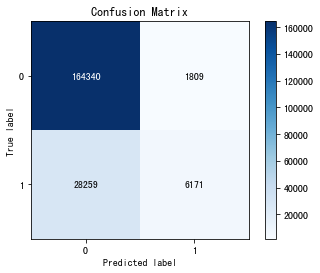

In [19]:
# 可视化
import scikitplot as skplt
import matplotlib.pyplot as plt

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

skplt.metrics.plot_confusion_matrix(y_train, y_train_pred)
plt.show()

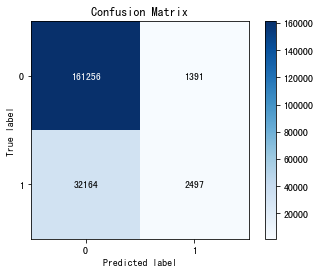

In [20]:
skplt.metrics.plot_confusion_matrix(y_valid, y_valid_pred)
plt.show()


In [36]:
import datetime
func_str2date = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date()
trx_start_dt, trx_end_dt = map(func_str2date, ["2017-02-01", "2017-10-31"])


In [37]:
trx_start_dt

datetime.date(2017, 2, 1)